In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial
from scipy.signal import fftconvolve

# Grid & square aperture 
L = 5.0  # mm, side length of square membrane
N = 500  # grid points per side 
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='xy')

A = np.ones_like(X)  # square aperture (all ones on grid)

rel_strength = 1

### Functions Declaration

In [2]:
# renormalization function on aperture to match unit power when clipped
def renorm(u): 
    uA = u * A
    return uA / (np.sqrt(np.sum(np.abs(uA)**2) * dx * dy) + 1e-30)

# Square membrane mechanical modes 
def drum_mode_square(x, y, L, kx=1, ky=1):
    # mode ~ sin(kx*pi*(x+L/2)/L) * sin(ky*pi*(y+L/2)/L)
    return np.sin(np.pi * kx * (x + L/2)/L) * np.sin(np.pi * ky * (y + L/2)/L)

# Hermite-Gaussian definitions (QM normalization on R, then re-norm on aperture) 
def HG_1D(x, n, sigma):
    # Normalized on infinite line with convention: exp(-x^2/(2 sigma^2))
    Hn = hermite(n)
    xi = x / sigma
    gauss = (1/(np.pi * sigma**2))**0.25 * np.exp(-x**2/(2*sigma**2))
    return gauss * Hn(xi) / np.sqrt(2**n * factorial(n))

def HG_2D(x, y, n, m, sigma_x, sigma_y):
    return HG_1D(x, n, sigma_x) * HG_1D(y, m, sigma_y)

# Build shifted optical fields to scan membrane
def optical_fields_product(X, Y, m, n, sigx, sigy, x0=0.0, y0=0.0):
    # Evaluate u_mn and u_00 at (x-x0, y-y0)
    u_mn = HG_2D(X - x0, Y - y0, n, m, sigx, sigy)  # note: HG_2D takes (x,y,n,m)
    u_00 = rel_strength * HG_2D(X - x0, Y - y0, 0, 0, sigx, sigy)
    
    return u_mn * u_00  # product field g_mn(x,y;x0,y0) (u_00 * u_mn)

# Direct inner product for a single (x0,y0) 
def overlap_at_offset(x0, y0, m, n, sigx, sigy):
    g = optical_fields_product(X, Y, m, n, sigx, sigy, x0, y0)
    return np.sum(phi * g) * dx * dy 

# Fast map via FFT 
def overlap_map(m, n, sigx, sigy):
    # Centered kernel g(x,y)=u_mn(x,y) u_00(x,y) at x0=y0=0
    u_mn_0 = HG_2D(X, Y, n, m, sigx, sigy)
    u_00_0 = rel_strength * HG_2D(X, Y, 0, 0, sigx, sigy)

    g0 = u_mn_0 * u_00_0

    # Convolution with flip: O(x0,y0) =  \int phi(x,y) g(x - x0, y - y0) dxdy
    # Discrete: phi * g[::-1, ::-1]
    O = fftconvolve(phi, g0[::-1, ::-1], mode='same') * dx * dy
    return O  # samples aligned to the same X,Y grid (x0,y0)


### Computations

In [3]:
# Choose a mechanical mode:
kx_mech, ky_mech = 2, 2
phi = drum_mode_square(X, Y, L, kx_mech, ky_mech) * A

# normalize mechanical mode (optional, for unitless comparability)
#phi /= np.sqrt(np.sum(np.abs(phi)**2) * dx * dy)

# Beam sizes (mm) for optical waist w, (exp(-x^2/w^2)), use sigma = w/√2.
sigma_x = 0.028  # mm
sigma_y = 0.028  # mm

# Choose HG indices (m,n)
m, n = 1, 1

# Single-point overlap at (x0,y0)
x0_test, y0_test = 0.5, -0.3  # mm
O_single = overlap_at_offset(x0_test, y0_test, m, n, sigma_x, sigma_y)
print(f"Overlap at (x0,y0)=({x0_test:.3f},{y0_test:.3f}) mm: {O_single:.6e}  (abs={abs(O_single):.6e})")

# Full map via FFT
Omap = overlap_map(m, n, sigma_x, sigma_y)

Overlap at (x0,y0)=(0.500,-0.300) mm: 4.653430e-04  (abs=4.653430e-04)


### Visualization

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_11538/3886583327.py:5: SyntaxWarning: invalid escape sequence '\p'
  axs[0].set_title(f"Mechanical mode $\phi$_{kx_mech}{ky_mech}")


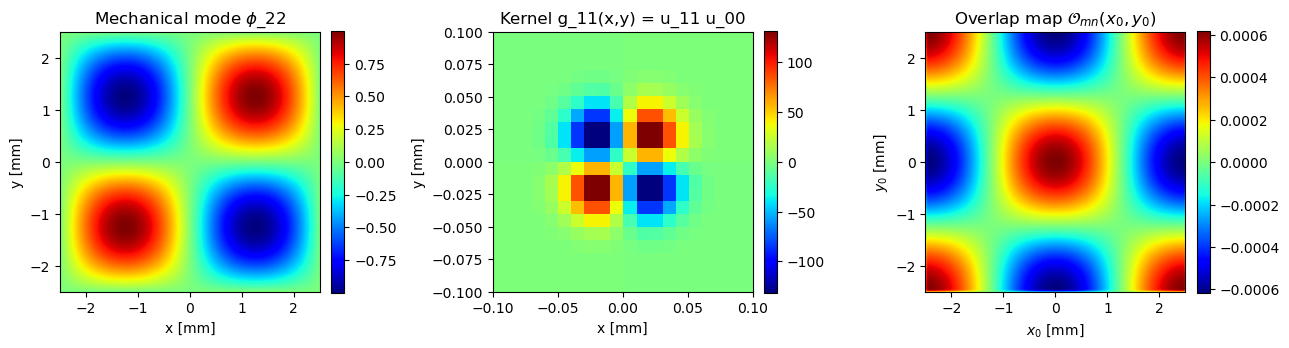

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))

im0 = axs[0].imshow(phi, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='jet')
axs[0].set_title(f"Mechanical mode $\phi$_{kx_mech}{ky_mech}")
axs[0].set_xlabel("x [mm]"); axs[0].set_ylabel("y [mm]")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Product kernel centered for intuition/visualization
u_mn_c = HG_2D(X, Y, n, m, sigma_x, sigma_y)
u_00_c = rel_strength * HG_2D(X, Y, 0, 0, sigma_x, sigma_y)

g_center = u_mn_c*u_00_c

im1 = axs[1].imshow(g_center, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='jet')
axs[1].set_title(f"Kernel g_{m}{n}(x,y) = u_{m}{n} u_00")
axs[1].set_xlabel("x [mm]"); axs[1].set_ylabel("y [mm]")
axs[1].set_ylim(-0.1, 0.1); axs[1].set_xlim(-0.1, 0.1)
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Overlap map 
im2 = axs[2].imshow(Omap, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='jet')
#axs[2].contour(x, y, np.abs(Omap), levels=6, linewidths=0.7)
axs[2].set_title(r"Overlap map $\mathcal{O}_{mn}(x_0,y_0)$")
axs[2].set_xlabel("$x_0$ [mm]"); axs[2].set_ylabel("$y_0$ [mm]")
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

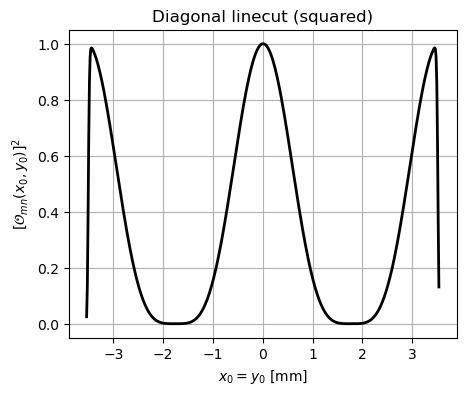

In [5]:
O_diag = np.diag(Omap)

# Plot linecut
plt.figure(figsize=(5,4))
plt.plot(x*np.sqrt(2), O_diag**2/np.max(O_diag**2), 'k-', lw=2)
plt.xlabel("$x_0 = y_0$ [mm]")
plt.ylabel(r"$[\mathcal{O}_{mn}(x_0, y_0)]^2$")
plt.title("Diagonal linecut (squared)")
plt.grid(True)
plt.show()

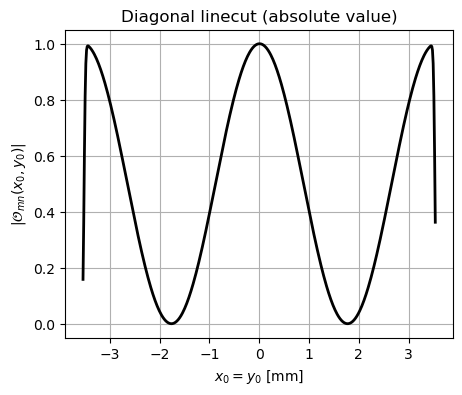

In [6]:
O_diag_abs = np.abs(O_diag)/np.max(np.abs(O_diag))

plt.figure(figsize=(5,4))
plt.plot(x*np.sqrt(2), O_diag_abs, 'k-', lw=2)
plt.xlabel("$x_0 = y_0$ [mm]")
plt.ylabel(r"$|\mathcal{O}_{mn}(x_0, y_0)|$")
plt.title("Diagonal linecut (absolute value)")
plt.grid(True)
plt.show()

In [7]:
np.savetxt('diagonal_abs_phi21_u00_u01.csv', O_diag_abs, delimiter=',')